Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.
Epoch 1/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 49s 311ms/step - accuracy: 0.5846 - loss: 1.1084 - val_accuracy: 0.7933 - val_loss: 0.5667
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 29s 226ms/step - accuracy: 0.7960 - loss: 0.5670 - val_accuracy: 0.8031 - val_loss: 0.5064
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.8410 - loss: 0.4743 - val_accuracy: 0.8386 - val_loss: 0.4819
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.8772 - loss: 0.3631 - val_accuracy: 0.8406 - val_loss: 0.4638
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.8894 - loss: 0.3122 - val_accuracy: 0.8346 - val_loss: 0.4705
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8902 - loss: 0.3110

📊 測試集準確率: 83.46%
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step


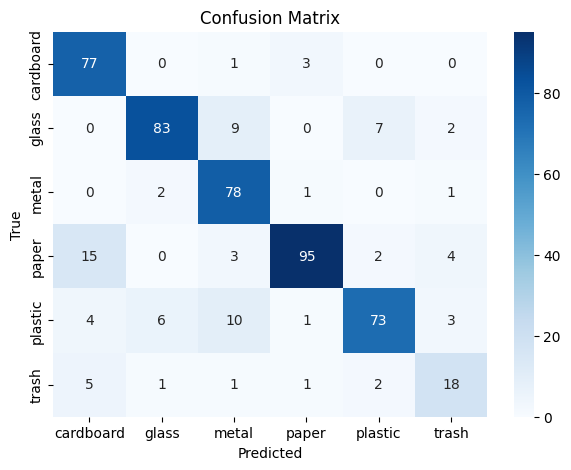


📋 Classification Report:

              precision    recall  f1-score   support

   cardboard       0.76      0.95      0.85        81
       glass       0.90      0.82      0.86       101
       metal       0.76      0.95      0.85        82
       paper       0.94      0.80      0.86       119
     plastic       0.87      0.75      0.81        97
       trash       0.64      0.64      0.64        28

    accuracy                           0.83       508
   macro avg       0.81      0.82      0.81       508
weighted avg       0.85      0.83      0.83       508



In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ===============================
# 1️⃣ 自動切分資料集
# ===============================
base_dir = '/content/drive/MyDrive/dataset-resized'
train_dir = '/content/train_split'
test_dir = '/content/test_split'

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            images = os.listdir(cls_path)
            train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

            os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
            os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

            for img in train_imgs:
                shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
            for img in test_imgs:
                shutil.copy(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))
    print(" 已自動分割 train/test 集合")

# ===============================
#  讀取資料
# ===============================
img_size = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ===============================
#  建立模型
# ===============================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # 冻結預訓練層

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ===============================
#  訓練模型
# ===============================
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5,
    verbose=1
)

# ===============================
#  評估與視覺化
# ===============================
test_loss, test_acc = model.evaluate(test_data)
print(f"\n 測試集準確率: {test_acc*100:.2f}%")

y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_data.class_indices.keys()),
            yticklabels=list(test_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))


In [10]:
# ============================================================
#  TrashNet 三模型比較實驗（小樣本版）
# ============================================================

import os, random, shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

#  準備小樣本資料（每類隨機50張）
# ============================================================
base_dir = '/content/drive/MyDrive/dataset-resized'
small_train = '/content/small_train_50'
if not os.path.exists(small_train):
    os.makedirs(small_train, exist_ok=True)
    for cls in os.listdir(base_dir):
        src = os.path.join(base_dir, cls)
        dst = os.path.join(small_train, cls)
        os.makedirs(dst, exist_ok=True)
        imgs = os.listdir(src)
        for f in random.sample(imgs, min(50, len(imgs))):
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))
    print(" 已建立小樣本資料集 (每類50張)")


#  建立資料產生器
# ============================================================
img_size = (128, 128)
batch_size = 8

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    small_train, target_size=img_size, batch_size=batch_size,
    subset='training', class_mode='categorical'
)
val_data = datagen.flow_from_directory(
    small_train, target_size=img_size, batch_size=batch_size,
    subset='validation', class_mode='categorical'
)

num_classes = train_data.num_classes

#  定義三種模型架構
# ============================================================

#  Thung2017_CNN（貼近文獻 5卷積+3全連接+Dropout+LogSoftMax）
def thung2017_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11,11), strides=4, padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),

        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
        layers.Activation('softmax')  # LogSoftMax 替代方案
    ])
    return model

#  Tran & Nguyen (2022) CNN
def tran2022_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# MobileNetV2
def mobilenetv2_model(input_shape, num_classes):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base.layers:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

#  模型清單與訓練設定
# ============================================================
models_dict = {
    "Thung2017_CNN": thung2017_cnn((128,128,3), num_classes),
    "Tran2022_CNN": tran2022_cnn((128,128,3), num_classes),
    "MobileNetV2": mobilenetv2_model((128,128,3), num_classes)
}

results = {}


#  訓練與評估
# ============================================================
for name, model in models_dict.items():
    print(f"\n🚀 Training {name}...")
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, validation_data=val_data, epochs=2, verbose=1,
                        steps_per_epoch=12, validation_steps=6)

    val_loss, val_acc = model.evaluate(val_data, verbose=0)
    results[name] = val_acc


#  輸出比較結果
# ============================================================
print("\n 模型準確率比較 (小樣本測試結果，每類50張)")
for k,v in results.items():
    print(f"{k:20s}: {v*100:.2f}%")


 已建立小樣本資料集 (每類50張)
Found 240 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

🚀 Training Thung2017_CNN...
Epoch 1/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.1046 - loss: 3.3603 - val_accuracy: 0.1667 - val_loss: 1.7999
Epoch 2/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1321 - loss: 1.8022 - val_accuracy: 0.1875 - val_loss: 1.7965

🚀 Training Tran2022_CNN...
Epoch 1/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.2741 - loss: 1.7928 - val_accuracy: 0.1875 - val_loss: 1.7918
Epoch 2/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3576 - loss: 1.6112 - val_accuracy: 0.1667 - val_loss: 1.7864

🚀 Training MobileNetV2...
Epoch 1/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 421ms/step - accuracy: 0.2559 - loss: 1.8896 - val_accuracy: 0.6042 - val_loss: 1.1337
Epoch 2/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5732 - loss: 1.1323 - val_accuracy: 0.5417 - val_loss: 1.1110

 模型準

In [11]:
# ============================================================
#  TrashNet 三模型比較實驗（全資料集版）
#    模型：Thung2017_CNN、Tran2022_CNN、MobileNetV2
# ============================================================

import os, shutil, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

#  新增：評估指標
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ============================================================
#  使用整個 TrashNet，自動切分 train / val (8:2)
# ============================================================
base_dir = '/content/drive/MyDrive/dataset-resized'   # 原始資料集（6 個類別資料夾）
train_dir = '/content/train_full'
val_dir   = '/content/val_full'

from sklearn.model_selection import train_test_split

if not os.path.exists(train_dir):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

        train_cls_dir = os.path.join(train_dir, cls)
        val_cls_dir   = os.path.join(val_dir, cls)
        os.makedirs(train_cls_dir, exist_ok=True)
        os.makedirs(val_cls_dir, exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(val_cls_dir, img))

    print(" 已使用『全部資料』自動分割 train_full / val_full (8:2)")
else:
    print("ℹ 偵測到已存在 train_full / val_full，跳過重新分割。")

# ============================================================
#  建立資料產生器（全資料集）
img_size = (224, 224)   # 統一 224x224，方便 MobileNetV2
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False   #  很重要：要算指標，不能 shuffle
)

num_classes = train_data.num_classes
input_shape = (img_size[0], img_size[1], 3)
class_names = list(val_data.class_indices.keys())
print("類別對應：", class_names)

# ============================================================
#  定義三種模型架構

#  Thung2017_CNN（5卷積 + 3全連接 + Dropout + softmax）
def thung2017_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Conv1
        layers.Conv2D(96, (11,11), strides=4, padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        # Conv2
        layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        # Conv3 & Conv4
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),

        # Conv5
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        layers.Flatten(),

        # FC6, FC7, FC8（3 全連接）
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes),
        layers.Activation('softmax')
    ])
    return model

#  Tran & Nguyen (2022) CNN（輕量 CNN）
def tran2022_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#  MobileNetV2（遷移學習）
def mobilenetv2_model(input_shape, num_classes):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base.layers:
        layer.trainable = False   # 先凍結 backbone，避免小資料 overfit 太快
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

# ============================================================
#  模型清單與訓練設定

models_dict = {
    "Thung2017_CNN": thung2017_cnn(input_shape, num_classes),
    "Tran2022_CNN": tran2022_cnn(input_shape, num_classes),
    "MobileNetV2":  mobilenetv2_model(input_shape, num_classes)
}

# results_acc 只放 accuracy；metrics_dict 放完整四個指標
results_acc = {}
metrics_dict = {}

# ===========================================================
#  訓練與評估（全資料集版本 + 多指標）

EPOCHS = 10

for name, model in models_dict.items():
    print(f"\n Training {name} on FULL dataset...")
    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        verbose=1
    )

    # Keras evaluate 的 acc（方便跟前面版本對照）
    val_loss, val_acc = model.evaluate(val_data, verbose=0)
    results_acc[name] = val_acc

    # 算 accuracy / precision / recall / F1（macro）
    val_data.reset()  # 確保 predict 從頭跑完整個驗證集
    y_true = val_data.classes       # 真實標籤 (0 ~ num_classes-1)
    y_prob = model.predict(val_data, verbose=0)  # 預測機率
    y_pred = np.argmax(y_prob, axis=1)       # 取最大機率的類別當預測

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    metrics_dict[name] = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    print(f" {name} - acc: {acc*100:.2f}%, precision(macro): {precision*100:.2f}%, "
          f"recall(macro): {recall*100:.2f}%, f1(macro): {f1*100:.2f}%")

# ============================================================
#  輸出比較結果（Accuracy + Precision + Recall + F1）

print("\n 模型準確率比較（全資料集 8:2 分割，Keras evaluate）")
for k, v in results_acc.items():
    print(f"{k:20s}: {v*100:.2f}%")

print("\n 模型指標比較（macro 平均）")
for name, m in metrics_dict.items():
    print(f"\n {name}")
    print(f"  Accuracy : {m['accuracy']*100:.2f}%")
    print(f"  Precision: {m['precision']*100:.2f}%")
    print(f"  Recall   : {m['recall']*100:.2f}%")
    print(f"  F1-score : {m['f1']*100:.2f}%")


ℹ️ 偵測到已存在 train_full / val_full，跳過重新分割。
Found 6 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
類別對應： ['cardboard']

 Training Thung2017_CNN on FULL dataset...


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7d4e70155170>

In [ ]:
# ============================================================
#  TrashNet 三模型比較實驗（全資料集版）(9:1)
#    模型：Thung2017_CNN、Tran2022_CNN、MobileNetV2
# ============================================================
import os, shutil, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

#  新增：評估指標
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ============================================================
#  使用整個 TrashNet，自動切分 train / val (9:1)
# ============================================================
base_dir = '/content/drive/MyDrive/dataset-resized'   # 原始資料集（6 個類別資料夾）
train_dir = '/content/train_full'
val_dir   = '/content/val_full'

from sklearn.model_selection import train_test_split

if not os.path.exists(train_dir):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        train_imgs, val_imgs = train_test_split(images, test_size=0.1, random_state=42)

        train_cls_dir = os.path.join(train_dir, cls)
        val_cls_dir   = os.path.join(val_dir, cls)
        os.makedirs(train_cls_dir, exist_ok=True)
        os.makedirs(val_cls_dir, exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(val_cls_dir, img))

    print(" 已使用『全部資料』自動分割 train_full / val_full (9:1)")
else:
    print(" 偵測到已存在 train_full / val_full，跳過重新分割。")

# ============================================================
#  建立資料產生器（全資料集）
img_size = (224, 224)   # 統一 224x224，方便 MobileNetV2
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False   # ⭐ 很重要：要算指標，不能 shuffle
)

num_classes = train_data.num_classes
input_shape = (img_size[0], img_size[1], 3)
class_names = list(val_data.class_indices.keys())
print("類別對應：", class_names)

# ============================================================
#  定義三種模型架構

#  Thung2017_CNN（5卷積 + 3全連接 + Dropout + softmax）
def thung2017_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Conv1
        layers.Conv2D(96, (11,11), strides=4, padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        # Conv2
        layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        # Conv3 & Conv4
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),

        # Conv5
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        layers.Flatten(),

        # FC6, FC7, FC8（3 全連接）
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes),
        layers.Activation('softmax')
    ])
    return model

#  Tran & Nguyen (2022) CNN（輕量 CNN）
def tran2022_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#  MobileNetV2（遷移學習）
def mobilenetv2_model(input_shape, num_classes):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base.layers:
        layer.trainable = False   # 先凍結 backbone，避免小資料 overfit 太快
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

# ============================================================
#  模型清單與訓練設定

models_dict = {
    "Thung2017_CNN": thung2017_cnn(input_shape, num_classes),
    "Tran2022_CNN": tran2022_cnn(input_shape, num_classes),
    "MobileNetV2":  mobilenetv2_model(input_shape, num_classes)
}

# results_acc 只放 accuracy；metrics_dict 放完整四個指標
results_acc = {}
metrics_dict = {}

# ===========================================================
#  訓練與評估（全資料集版本 + 多指標）

EPOCHS = 10

for name, model in models_dict.items():
    print(f"\n Training {name} on FULL dataset...")
    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        verbose=1
    )

    # Keras evaluate 的 acc（方便跟前面版本對照）
    val_loss, val_acc = model.evaluate(val_data, verbose=0)
    results_acc[name] = val_acc

    # 算 accuracy / precision / recall / F1（macro）
    val_data.reset()  # 確保 predict 從頭跑完整個驗證集
    y_true = val_data.classes     # 真實標籤 (0 ~ num_classes-1)
    y_prob = model.predict(val_data, verbose=0)  # 預測機率
    y_pred = np.argmax(y_prob, axis=1)      # 取最大機率的類別當預測

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    metrics_dict[name] = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    print(f" {name} - acc: {acc*100:.2f}%, precision(macro): {precision*100:.2f}%, "
          f"recall(macro): {recall*100:.2f}%, f1(macro): {f1*100:.2f}%")

# ============================================================
#  輸出比較結果（Accuracy + Precision + Recall + F1）

print("\n 模型準確率比較（全資料集 8:2 分割，Keras evaluate）")
for k, v in results_acc.items():
    print(f"{k:20s}: {v*100:.2f}%")

print("\n 模型指標比較（macro 平均）")
for name, m in metrics_dict.items():
    print(f"\n {name}")
    print(f"  Accuracy : {m['accuracy']*100:.2f}%")
    print(f"  Precision: {m['precision']*100:.2f}%")
    print(f"  Recall   : {m['recall']*100:.2f}%")
    print(f"  F1-score : {m['f1']*100:.2f}%")
